In [1]:
import warnings
import datetime
import itertools
import numpy as np
import scipy as sp
import cvxpy as cp
import pandas as pd
import yfinance as yf
import seaborn as sns
import ipywidgets as widgets
import matplotlib.pyplot as plt
from functools import reduce
from kit import interval_dict, annualize_returns, annualize_vol, get_yf_ts

warnings.filterwarnings('ignore')

In [45]:
rf = get_yf_ts("^IRX", '10y', "1mo") / 100 # Expressed in % hence the division
rf = rf.resample('M').interpolate('linear')

Cox Ingersoll Ross model for dynamics of interest rates; The change of the interest rates depends on the current interest rates, plus some noise factor: $\newline$
$dr_t = a(b - r_t) dt + \sigma \sqrt{r_t}dW_t$ $\newline$ for $a$ being the mean reversion parameter, $b$ the long-term mean of interest rates, $r_t$ the current interest rate, the volatility $\sigma$ and Brownian noise $W_t$.

In [50]:
def cir(scenarios=10, a=0.5, b=0.03, r_0=0.03, sigma=0.05, freq=12, vasicek=False, rf=None):
    years = rf.shape[0] // 12
    r_0 = np.log1p(r_0)
    dt = 1 / freq
    n_payments = years * freq
    
    noise = np.random.normal(0, np.sqrt(dt), (n_payments, scenarios))
    
    rates = np.array([[r_0] * scenarios])
    for ix in range(1, n_payments):
        r_t = rates[ix - 1]
        d_r_t = a * (b - r_t) * dt + sigma * noise[ix] * (np.sqrt(r_t) if vasicek else 1)
        rates = np.concatenate([rates, r_t + d_r_t.reshape(1, scenarios)])
    
        
    return pd.DataFrame(np.expm1(rates), index=rf.index)

In [57]:
b = rf["^IRX"].mean()
r_0 = rf["^IRX"].iloc[-1]
sigma = rf["^IRX"].std() * np.sqrt(12)

Note, the standard version of the CIR model takes the absolute value of the sum of mean reversion part and the noise, because the noise can cause negative interest rates. With $\sigma$ high enough in the unconstrained version, we'll probably see a few scenarios where interest rates are slightly below 0. This does not necessarily represent their actual likelihood of occurring, as even in deep recessions monetary policies for negative interest rates are rare.

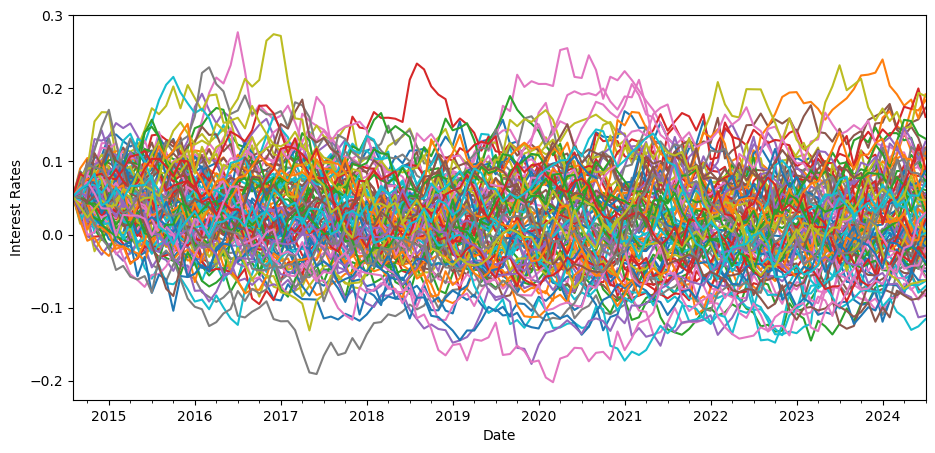

In [58]:
cir(a=0.5, b=b, r_0=r_0, sigma=sigma, scenarios=100, rf=rf).plot(legend=False, figsize=(11, 5), ylabel='Interest Rates')
plt.show()

Use of the Cox Ingersoll Ross model for zero coupon bond pricing:
$$P(t,T)=A(T - t)e^{-B(T - t)r_{t}}\! \newline $$
$$ A(\tau)=\left({\frac  {2h e^{(a+h)\tau/2}}{2h+(a+h)(e^{\tau h}-1)}}\right)^{{2ab/\sigma ^{2}}} \newline $$
$$ B(\tau)={\frac  {2(e^{\tau h}-1)}{2h+(a+h)(e^{\tau h}-1)}} \newline$$
$$ h={\sqrt  {a^{2}+2\sigma ^{2}}} \newline$$
$$\tau = T - t$$

In [60]:
def zcb(h, a, b, tau, sigma, r):
    A_power = 2 * a * b / sigma ** 2
    A = ((2 * h * np.exp((h + a) * tau / 2)) / (2 * h + (h + a) * (np.exp(h * tau) - 1))) ** A_power
    B = (2 * (np.exp(h * tau) - 1)) / (2 * h + (h + a) * (np.exp(h * tau) - 1))
    return A * np.exp(-B * r)

def cir_zcb(scenarios=100, a=0.5, b=0.03, r_0=0.03, sigma=0.05, freq=12, s_0=100, rf=None):
    years = rf.shape[0] // 12
    r_0 = np.log1p(r_0)
    dt = 1 / freq
    n_payments = years * freq
    
    noise = np.random.normal(0, np.sqrt(dt), (n_payments, scenarios))
    rates = np.empty_like(noise)
    rates[0] = r_0
    
    h = np.sqrt(a ** 2 + 2 * sigma ** 2)
    prices = np.empty_like(noise) 
    prices[0] = zcb(h, a, b, years, sigma, r_0)

    for ix in range(1, n_payments):
        r_t = rates[ix - 1]
        d_r_t = a * (b - r_t) * dt + sigma * np.sqrt(r_t) * noise[ix]
        rates[ix] = abs(r_t + d_r_t)
        prices[ix] = zcb(h, a, b, years - (ix * dt), sigma, rates[ix])

    rates = pd.DataFrame(data=np.log1p(rates), index=rf.index)
    prices = s_0 * pd.DataFrame(data=prices, index=rf.index)
    return rates, prices


In the simulations below, we observe how the rates impact the price and how the mean reversion parameter affects the price volatility. Naturally, rates and prices are negatively correlated and a higher mean reversion $a$ will make the price smoothly transition between its initial discounted value and maturity value, with $a=1$ it's nearing a linear change between the prices and with $a=0$ the price follows the flipped random walk as our CIR generated rates.

Rates, prices correlation -0.874457342357951


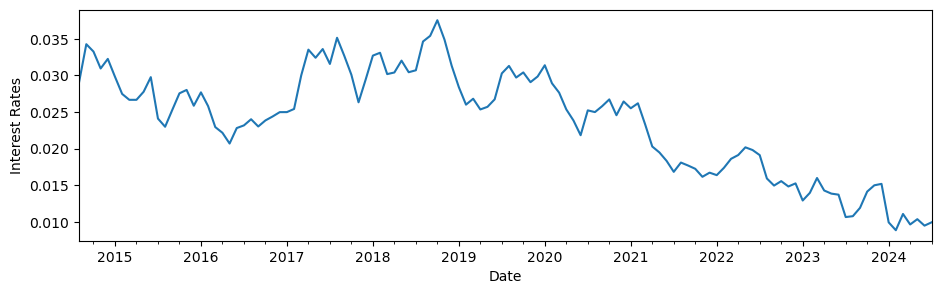

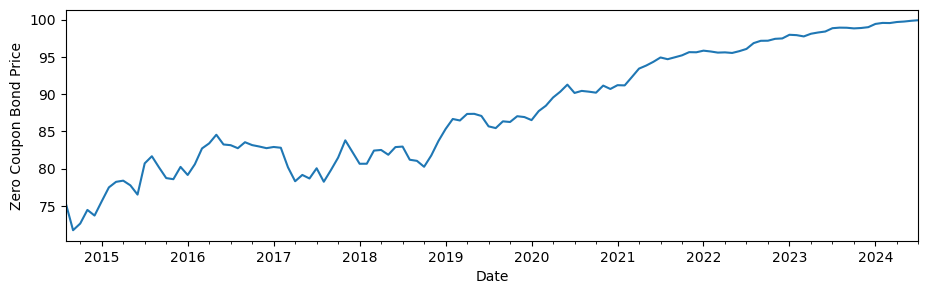

In [67]:
rates, prices = cir_zcb(scenarios=1, a=0, rf=rf)
print("Rates, prices correlation {}".format(rates[0].corr(prices[0])))
rates.plot(legend=False, figsize=(11,3), ylabel='Interest Rates')
prices.plot(legend=False, figsize=(11,3), ylabel='Zero Coupon Bond Price')
plt.show()

Rates, prices correlation -0.7088095165706153


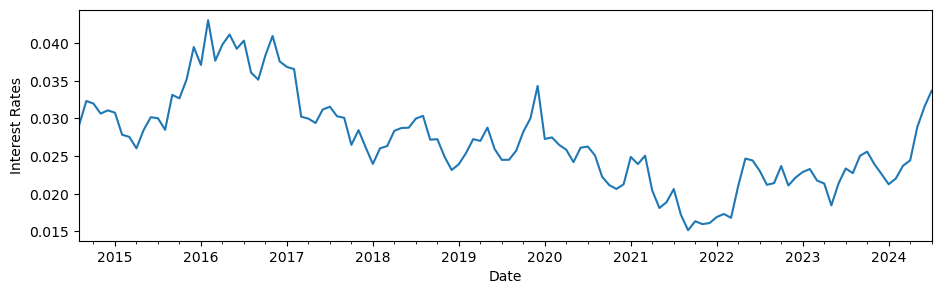

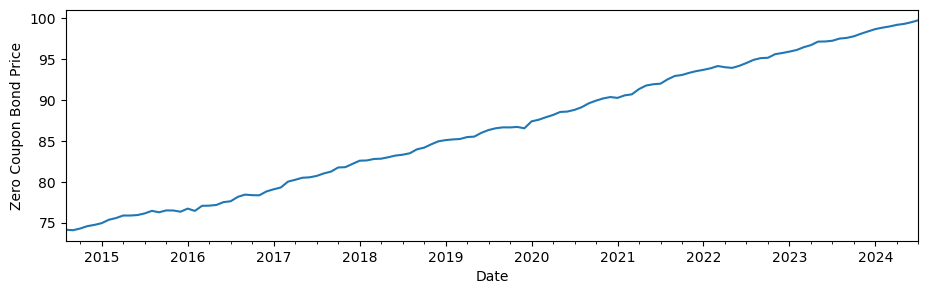

In [69]:
rates, prices = cir_zcb(scenarios=1, a=1, rf=rf)
print("Rates, prices correlation {}".format(rates[0].corr(prices[0])))
rates.plot(legend=False, figsize=(11,3), ylabel='Interest Rates')
prices.plot(legend=False, figsize=(11,3), ylabel='Zero Coupon Bond Price')
plt.show()